# Feature engineering

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pyLDAvis.sklearn

from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import KMeans, MiniBatchKMeans, AgglomerativeClustering, FeatureAgglomeration
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import silhouette_score, silhouette_samples, davies_bouldin_score, calinski_harabasz_score, homogeneity_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy.cluster import hierarchy

from wordcloud import WordCloud
from textwrap import wrap
from textblob import TextBlob
from textstat import flesch_reading_ease, difficult_words, automated_readability_index, text_standard

import nltk
from nltk.corpus import stopwords

import category_encoders as ce

import re
import warnings
warnings.filterwarnings("ignore")

import random
random.seed(123)

c:\users\gabriela kurek\pycharmprojects\wumpd1\venv\lib\site-packages\patsy\constraint.py:13: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.9 it will stop working
  from collections import Mapping


## Wczytanie i obrobienie pliku

In [2]:
file = open('Complete_data .txt', 'r')
file_content = file.read()
file.close()


content_list = re.split('\d+\.\d+', file_content)
indices = []
corpus = []
for idx in range(len(content_list)):
    stripped = content_list[idx].strip()
    if stripped != '':
        corpus.append(content_list[idx])
corpus.pop(13)

'\n§ 14.\n'

## Długości wyrazów, zdań i ilość znaków

In [3]:
df_corpus = pd.DataFrame({'text': corpus})

In [4]:
df_corpus['words_count'] = df_corpus['text'].apply(lambda x: len(re.findall('[^\d\W]+', x)))

In [5]:
df_corpus['sentences_count'] = df_corpus['text'].apply(lambda x: len(re.split('\.{1}\s{1}[A-Z]', x)))

In [6]:
df_corpus['letters_count'] = df_corpus['text'].apply(lambda x: len(re.findall('[a-z|A-Z]', x)))

In [7]:
df_corpus['avg_word_length'] = df_corpus['letters_count'] / df_corpus['words_count']
df_corpus['avg_sentence_length'] = df_corpus['words_count'] / df_corpus['sentences_count']

## Zliczanie wyrazów bez stop words

In [8]:
c_vectorizer2 = CountVectorizer(stop_words='english', token_pattern=r"\b[^\d\W]+\b")
cv2 = c_vectorizer2.fit_transform(corpus)

cv_features2 = c_vectorizer2.get_feature_names()
df_all = pd.DataFrame(cv2.toarray(), columns=list(cv_features2))

In [9]:
df_corpus['words_count_wo_stopwords'] = df_all.sum(axis=1)

Zliczenie wyrazów nie powtarzających się.

In [10]:
arr = np.array(df_all)
arr = arr >=1
arr = arr.astype(int)

df_ex = pd.DataFrame(arr, columns = df_all.columns)

df_corpus['unique_words_count'] = df_ex.sum(axis = 1)

In [11]:
df_corpus

,text,words_count,sentences_count,letters_count,avg_word_length,avg_sentence_length,words_count_wo_stopwords,unique_words_count
0,"\n§ 1.The Buddha: ""What do you think, Rahula: ...",609,14,2839,4.661741,43.500000,292,82
1,\n§ 2.Once the Blessed One was staying at Kosa...,272,13,1171,4.305147,20.923077,104,46
2,"\n§ 3.""'Stress should be known. The cause by w...",378,15,1730,4.576720,25.200000,182,76
3,"\n§ 4.""Vision arose, clear knowing arose, disc...",267,16,1239,4.640449,16.687500,120,43
4,"\n§ 5.Sariputta: ""There are these three forms ...",30,2,175,5.833333,15.000000,13,7
...,...,...,...,...,...,...,...,...
585,\ncondemning both the makers and the worshippe...,540,23,2241,4.150000,23.478261,217,160
586,"\nworthily punished, and were destroyed by a m...",803,36,3495,4.352428,22.305556,338,215
587,"\n 17:1. For thy judgments, O Lord, are great,...",531,23,2411,4.540490,23.086957,208,172
588,"\nintercession, in the sedition on occasion of...",745,33,3302,4.432215,22.575758,311,231


## Analiza bloku tekstu

In [12]:
def polarity(text):
    return TextBlob(text).sentiment.polarity

def subjectivity(text):
    return TextBlob(text).sentiment.subjectivity

df_corpus['polarity'] = df_corpus['text'].apply(lambda x : polarity(x))
df_corpus['subjectivity'] = df_corpus['text'].apply(lambda x : subjectivity(x))

## Analiza złożoności tekstu

In [13]:
df_corpus['FRE'] = df_corpus['text'].apply(lambda x : flesch_reading_ease(x))
df_corpus['ARI'] = df_corpus['text'].apply(lambda x : automated_readability_index(x))

## LDA
Czyli przypisanie tekstom tematów przewodnich.

In [14]:
c_vectorizer = CountVectorizer(max_df=0.9, min_df=2, stop_words='english', token_pattern=r"\b[^\d\W]+\b")
cv = c_vectorizer.fit_transform(corpus)

cv_features = c_vectorizer.get_feature_names()
df_word_count = pd.DataFrame(cv.toarray(), columns=list(cv_features))

In [15]:
lda_model = LatentDirichletAllocation(n_components=8, 
                                      learning_method='batch', 
                                      max_iter=300, 
                                      random_state=0).fit(cv)

In [16]:
no_top_words = 10
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]
                            for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [17]:
display_topics(lda_model, c_vectorizer.get_feature_names(), no_top_words)

Topic 0:
consciousness things spiritual object life mind perception soul attention power
Topic 1:
shall lord god earth things like glory great wisdom people
Topic 2:
shall thy man thou hath thee things god good heart
Topic 3:
life spiritual power self man said world mind eternal property
Topic 4:
stress called cessation clinging right having fabrications form feeling consciousness
Topic 5:
man spiritual self consciousness mind know life knowledge true nature
Topic 6:
mind right remains body focused discerns feeling monk qualities mindfulness
Topic 7:
tao does state heaven s great things men sage pleasure


### Proponowane przez nas tematy

0. Mind Perception and Soul
1. Lord of Earth and Wisdom
2. Christianity - God
3. Spiritual Power and Eternal Property
4. Feeling and Consciousness
5. Spiritual Man Life and Consciousness
6. Monk - Body and Mind
7. Tao and Heaven

## Tf-idf
Przypisanie w tekstach wag słowom.

In [18]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.9, min_df=2, use_idf=True, stop_words='english', token_pattern=r"\b[^\d\W]+\b")

tfidf = tfidf_vectorizer.fit_transform(corpus)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

df_tfidf = pd.DataFrame(tfidf.toarray(), columns=list(tfidf_feature_names))

### Wyznaczenie tematów z wykorzystanie ramki zawierającej wagi słów

In [19]:
nmf = NMF(n_components=8, random_state=0, alpha=.1, init='nndsvd').fit(tfidf)
display_topics(nmf, tfidf_feature_names, no_top_words)

Topic 0:
shall man hath wicked god lord just wise wisdom fool
Topic 1:
spiritual man consciousness powers power life psychical psychic divine soul
Topic 2:
thy thou thee shalt let hast hath shall god lest
Topic 3:
mind senses intellect atman objects higher control know driver eye
Topic 4:
tao does things heaven great men know sage people state
Topic 5:
brahman said devas vayu nachiketas know replied able indra worship
Topic 6:
self beings eternal sees seated life atman sorrow body soul
Topic 7:
right stress cessation feeling consciousness fabrications noble monk concentration perception


0. Lord's Wisdom
1. Spirituality and Consciousness
2. Christianity - God
3. Mind and Intellect
4. Tao does great things
5. Brahman and Worship
6. Hinduism - Eternal Beings 
7. Noble Monk Perception

Przypisanie tematów do tekstów.

In [20]:
nmf_topic_values = nmf.transform(tfidf)
df_corpus['nmf_topics'] = nmf_topic_values.argmax(axis=1)
lda_topic_values = lda_model.transform(cv)
df_corpus['lda_topics'] = lda_topic_values.argmax(axis=1)

nmf_remap = {0: 'Lord\'s Wisdom', 
           1: 'Spirituality and Consciousness', 
           2: 'Christianity - God', 
           3: 'Mind and Intellect', 
           4: 'Tao does great things', 
           5: 'Brahman and Worship', 
           6: 'Hinduism - Eternal Beings', 
           7: 'Noble Monk Perception'}

df_corpus['nmf_topics'] = df_corpus['nmf_topics'].map(nmf_remap)

lda_remap = {0: 'Mind Perception and Soul',
            1: 'Lord of Earth and Wisdom',
            2: 'Christianity - God 2',
            3: 'Spiritual Power and Eternal Property',
            4: 'Feeling and Consciousness',
            5: 'Spiritual Man Life and Consciousness',
            6: 'Monk - Body and Mind',
            7: 'Tao and Heaven'}

df_corpus['lda_topics'] = df_corpus['lda_topics'].map(lda_remap)

In [21]:
df_corpus.head()

,text,words_count,sentences_count,letters_count,avg_word_length,avg_sentence_length,words_count_wo_stopwords,unique_words_count,polarity,subjectivity,FRE,ARI,nmf_topics,lda_topics
0,"\n§ 1.The Buddha: ""What do you think, Rahula: ...",609,14,2839,4.661741,43.500000,292,82,-0.059836,0.395902,38.28,19.2,Noble Monk Perception,Feeling and Consciousness
1,\n§ 2.Once the Blessed One was staying at Kosa...,272,13,1171,4.305147,20.923077,104,46,0.117647,0.477941,80.01,9.0,Noble Monk Perception,Feeling and Consciousness
2,"\n§ 3.""'Stress should be known. The cause by w...",378,15,1730,4.576720,25.200000,182,76,0.180979,0.547078,71.24,10.3,Noble Monk Perception,Feeling and Consciousness
3,"\n§ 4.""Vision arose, clear knowing arose, disc...",267,16,1239,4.640449,16.687500,120,43,0.343080,0.664732,62.88,10.1,Noble Monk Perception,Feeling and Consciousness
4,"\n§ 5.Sariputta: ""There are these three forms ...",30,2,175,5.833333,15.000000,13,7,0.000000,0.000000,64.71,15.9,Noble Monk Perception,Feeling and Consciousness


## Zakodujemy kolumny z tematami

In [22]:
oh = ce.OneHotEncoder(cols=['nmf_topics', 'lda_topics'], use_cat_names=True)

df_corpus_enc = oh.fit_transform(df_corpus)

In [23]:
df_corpus_enc.shape

(590, 28)

## Normalizacja wybranych cech
Znormalizujemy kolumny które posiadają wartości z zakresu przekraczającego przedział [-1, 1].

**Kolumny**:
- `FRE`,
- `ARI`,
- `words_count`,
- `sentences_count`,
- `letters_count`,
- `avg_word_length`,
- `avg_sentence_length`,
- `words_count_wo_stopwords`,
- `unique_words_count`

In [24]:
cols_to_normalize = ['words_count', 'sentences_count', 'letters_count', 'avg_word_length',
                     'avg_sentence_length', 'words_count_wo_stopwords', 'unique_words_count', 'ARI', 'FRE']

df_corpus_enc.loc[:, cols_to_normalize] = StandardScaler().fit_transform(df_corpus_enc.loc[:, cols_to_normalize])

# Klasteryzacja

## KMeans

### Dobór liczby klastrów
Sprawdzimy jaki podział proponują różne metody, następnie podzielimy obserwacje na klastry metodą KMeans dla wybranych liczb klastrów. Na koniec sprawdzimy accuracy dla każdego podziału.
#### Metoda łokcia

In [25]:
def elbow_method(df, k_max):
    scores = []
    for k in range(1, k_max+1):
        kmeans = KMeans(random_state=0, n_clusters=k).fit(df)
        scores.append(kmeans.score(df) * -1)
    return scores

In [26]:
X = df_corpus_enc.iloc[:, 1:-1]
k_max = 12
scores = elbow_method(X, k_max)

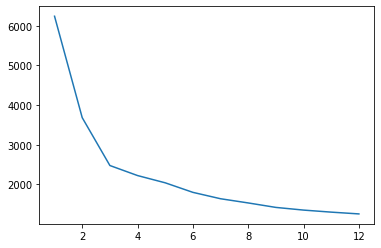

In [27]:
x = list(range(1,k_max + 1))
plt.plot(x, scores)
plt.show()

Według tej metody powinniśmy wybrać 3 lub 4 klastry.

In [28]:
def clustering_scores(X, cluster_num, model_class, score_fun):
    if isinstance(cluster_num, int):
        cluster_num_iter = [cluster_num]
    else:
        cluster_num_iter = cluster_num
        
    scores = []    
    for k in cluster_num_iter:
        model_instance = model_class(n_clusters=k)
        labels = model_instance.fit_predict(X)
        wcss = score_fun(X, labels)
        scores.append(wcss)
    
    if isinstance(cluster_num, int):
        return scores[0]
    else:
        return scores

#### Silhouette
Im wyższy wynik tym lepszy podział.
Widzimy na wykresie, że z tego wynika, że najlepszy jest podział na 2 lub 3 klastry.

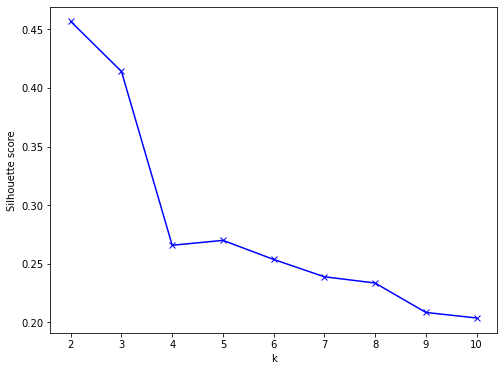

In [29]:
figsize=[8, 6]

cluster_num_seq = range(2, 11) 
silhouette_vec = clustering_scores(X, cluster_num_seq, KMeans, silhouette_score)
f = plt.figure(figsize=figsize)
plt.plot(cluster_num_seq, silhouette_vec, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette score')
plt.show()

#### Davies-Bouldin

Niższy wynik oznacza lepsze rozdzielenie klastrów. Zero to najlepszy możliwy wynik.
Ponownie możemy zaobserwować, że proponowany jest podział na dwa lub 3 klastry.

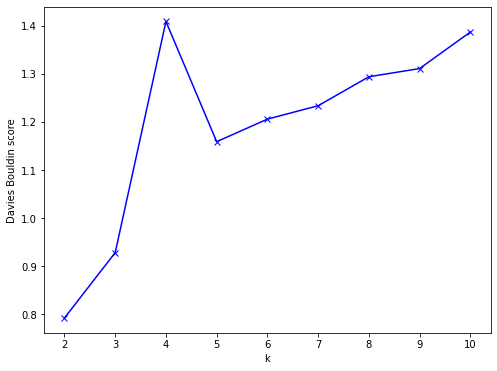

In [30]:
cluster_num_seq = range(2, 11) 
db_vec = clustering_scores(X, cluster_num_seq, KMeans, davies_bouldin_score)
f = plt.figure(figsize = figsize)
plt.plot(cluster_num_seq, db_vec, 'bx-')
plt.xlabel('k')
plt.ylabel('Davies Bouldin score')
plt.show()

#### Caliński -  Harabasz score
Im wyższy wynik metryki tym lepszy podział

**Zalety**
- wynik jest wyższy dla klastrów gęstych i dobrze oddzielonych

**Wady**
- ten indeks faworyzuje klastry wypukłe

W przypadku tej metryki wygląda na to, że im więcej klastrów tym lepiej.

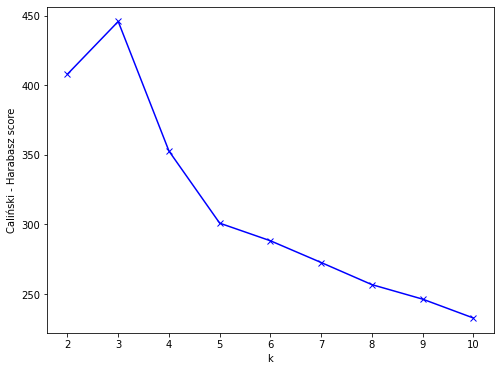

In [31]:
ch_vec = clustering_scores(X, cluster_num_seq, KMeans, calinski_harabasz_score)

f = plt.figure(figsize = figsize)
plt.plot(cluster_num_seq, ch_vec, 'bx-')
plt.xlabel('k')
plt.ylabel('Caliński - Harabasz score')
plt.show()

Ponieważ większość metryk pomagających w doborze liczby klastrów proponowała podział na 3 lub 2 klastry. Sprawdzimy accuracy dla tego podziału.

### Sprawdzenie accuracy
W celu sprawdzenia poprawności naszej klasteryzacji, wczytamy etykiety.
Będziemy sprawdzać poprawność klasteryzacji pod kątem podziału na religie, czyli możliwe są 4 kategorie.

**Wczytanie etykiet**

In [32]:
labels = pd.read_csv('AllBooks_baseline_DTM_Labelled.csv')
labels = labels.iloc[:, 0]
def f(x):
    s = x.split('_')
    return s[0]
labels = np.vectorize(f)(labels)

In [33]:
df_corpus_enc['label'] = labels
df_corpus_enc['label'].unique()
book_dict = {'Buddhism': 'Buddhism', 'TaoTeChing': 'Taoism', 'Upanishad': 'Hiduism' , 'YogaSutra': 'Hiduism',
       'BookOfProverb': 'Christianity', 'BookOfEcclesiastes': 'Christianity', 'BookOfEccleasiasticus': 'Christianity',
       'BookOfWisdom': 'Christianity'}
df_corpus_enc['label'] = df_corpus_enc['label'].replace(book_dict)

### Funkcja licząca accuracy
Funkcja dokonuje klasteryzacji na podaną liczbę klastrów, a następnie dla każdego klastra zlicza liczbę obserwacji z danej klasy. Klaster dostaje etykietę klasy, której obserwacji w danym klastrze jest najwięcej. 

Następnie określa liczbę poprawnie sklasyfikowanych obserwacji i dzieli to przez liczbę wszystkich obserwacji.

In [34]:
def check_accuracy(model, X, n_clusters, labels):
    results = []
    for k in n_clusters:
        m = model(n_clusters=k)
        result = m.fit_predict(X)
        
        lbl_dict = {}
        for i in range(k):
            # przypisanie etykiety dla k-tego klastra
            lbl_dict[i] = labels.loc[result == i].groupby(by='label').size().sort_values(ascending=False).index[0]
            
        result = pd.DataFrame(result)
        assigned_labels = result.replace(lbl_dict)        
        print(f'Przydzielone klasy: {assigned_labels.iloc[:, 0].unique()}')
        
        accuracy = np.sum(np.array(labels) == np.array(assigned_labels)) / 590
        print(f'Accuracy: {accuracy}')
        
check_accuracy(KMeans, X, [2, 3], df_corpus_enc)

Przydzielone klasy: ['Christianity' 'Hiduism']
Accuracy: 0.7745762711864407
Przydzielone klasy: ['Christianity' 'Hiduism' 'Taoism']
Accuracy: 0.8220338983050848


## PCA

Spróbujemy zredukować wymiarowość ramki stosując PCA.

In [35]:
pca = PCA().fit(X)

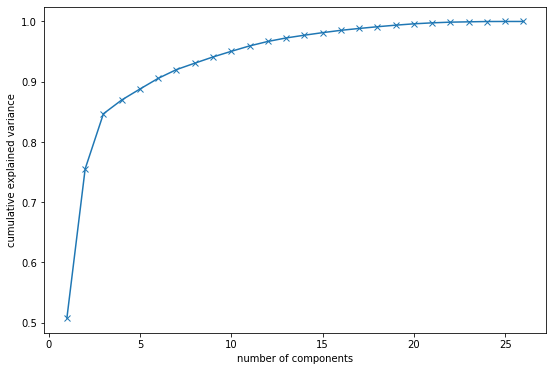

In [36]:
plt.figure(figsize=(9,6))
plt.plot(range(1, len(pca.explained_variance_ratio_)+1), np.cumsum(pca.explained_variance_ratio_),marker='x')
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

Wynik jest ciekawy, okazuje się, że możemy zredukować nasze dane do dwóch wymiarów.

In [37]:
X_pca = PCA(n_components=2).fit_transform(X)

In [38]:
X_pca = pd.DataFrame({'x': X_pca[:, 0], 'y': X_pca[:, 1], 'label': df_corpus_enc['label']})

In [39]:
def plot_kmeans_clusters(X, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    kmeans.fit(X)
    y_kmeans = kmeans.predict(X)
    plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y_kmeans, s=30, cmap='viridis')

    centers = kmeans.cluster_centers_
    plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.75)
    plt.title('K-means clusters')
    plt.show()

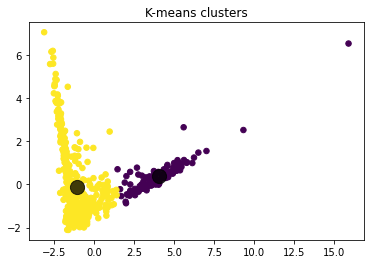

In [40]:
plot_kmeans_clusters(X_pca.loc[:, ['x', 'y']], 2)

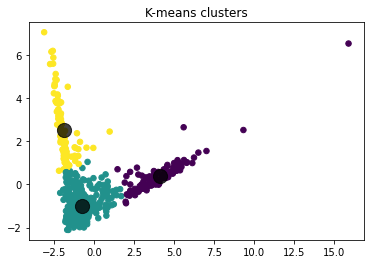

In [41]:
plot_kmeans_clusters(X_pca.loc[:, ['x', 'y']], 3)

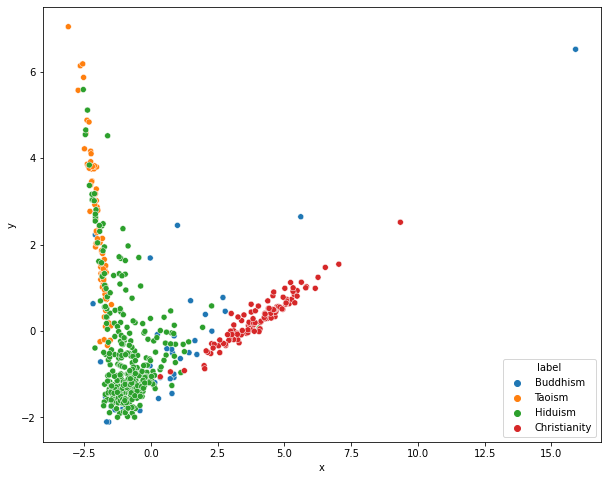

In [42]:
f = plt.figure(figsize=[10, 8])
sns.scatterplot(data=X_pca, x='x', y='y', hue='label')
plt.show()

## Obserwacje
Najbardziej od wszystkich odstają teksty chrześcijańskie. Ciężko jest znaleźć granicę między tekstami innych religii, szczególnie, że tekstów z hinduizmu jest dużo więcej niż taoizmu i buddyzmu. 

W miarę dobrym podziałem jest klasteryzacja przy pomocy KMeans na trzy klastry.

## TSNE

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 590 samples in 0.001s...
[t-SNE] Computed neighbors for 590 samples in 0.024s...
[t-SNE] Computed conditional probabilities for sample 590 / 590
[t-SNE] Mean sigma: 0.865664
[t-SNE] KL divergence after 250 iterations with early exaggeration: 62.847153
[t-SNE] KL divergence after 1000 iterations: 0.570289


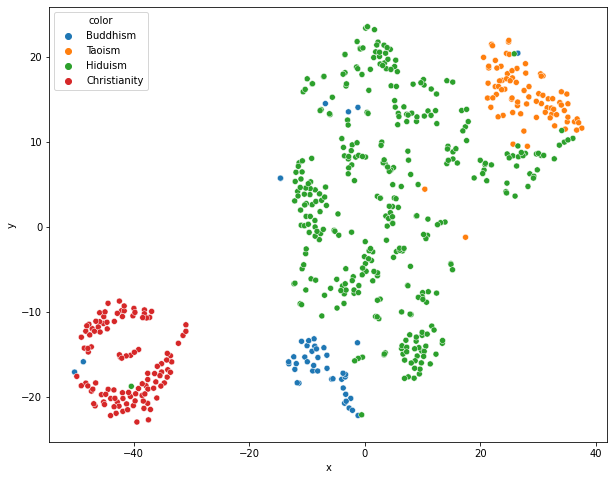

In [43]:
random_state = 156897
plt.figure(figsize=[10, 8])
tSNE = TSNE(random_state=random_state, verbose=1)
t = tSNE.fit_transform(X)
t = pd.DataFrame({'x': t[:, 0], 'y': t[:, 1], 'color': df_corpus_enc['label']})
sns.scatterplot(data=t, x='x', y='y', hue='color')
plt.show()

Wizualizacja pokazuje, że są widoczne różnice pomiędzy tekstami. Najbardziej oddalone od pozostałych są teksty chrześcijańskie. 

## Klasteryzacja hierarchiczna 
### Ustalenie liczby klastrów

In [44]:
df_encoded = pd.read_csv("df_corpus_encoded.csv")
df_encoded = df_encoded.iloc[:,2:]
df = pd.read_csv("AllBooks_baseline_DTM_Unlabelled.csv")

In [45]:
df_encoded

,words_count,sentences_count,letters_count,avg_word_length,avg_sentence_length,words_count_wo_stopwords,unique_words_count,polarity,subjectivity,FRE,...,nmf_topics_Christianity - God,nmf_topics_Spirituality and Consciousness,lda_topics_Feeling and Consciousness,lda_topics_Spiritual Power and Eternal Property,lda_topics_Monk - Body and Mind,lda_topics_Spiritual Man Life and Consciousness,lda_topics_Mind Perception and Soul,lda_topics_Tao and Heaven,lda_topics_Lord of Earth and Wisdom,lda_topics_Christianity - God 2
0,1.717756,0.451745,1.962226,0.517320,-0.186452,2.003568,0.306691,-0.059836,0.395902,0.157529,...,0,0,1,0,0,0,0,0,0,0
1,0.243078,0.368246,0.239948,-0.357043,-0.637340,0.109040,-0.316551,0.117647,0.477941,0.925323,...,0,0,1,0,0,0,0,0,0,0
2,0.706923,0.535244,0.817139,0.308850,-0.551925,0.895067,0.202818,0.180979,0.547078,0.763963,...,0,0,1,0,0,0,0,0,0,0
3,0.221198,0.618743,0.310161,0.465115,-0.721929,0.270276,-0.368487,0.343080,0.664732,0.610146,...,0,0,1,0,0,0,0,0,0,0
4,-0.815890,-0.550246,-0.788462,3.390052,-0.755631,-0.807993,-0.991729,0.000000,0.000000,0.643817,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
585,1.415819,1.203238,1.344767,-0.737462,-0.586310,1.247772,1.657049,0.010802,0.569444,0.781442,...,1,0,0,0,0,0,0,0,0,1
586,2.566680,2.288728,2.639573,-0.241110,-0.609730,2.467122,2.609224,0.133667,0.569179,0.792666,...,1,0,0,0,0,0,0,0,0,1
587,1.376435,1.203238,1.520299,0.220014,-0.594125,1.157076,1.864796,-0.076437,0.650194,0.768379,...,0,0,0,0,0,0,0,0,0,1
588,2.312878,2.038230,2.440293,-0.045474,-0.604334,2.195036,2.886220,0.042108,0.597840,0.800209,...,1,0,0,0,0,0,0,0,0,1


In [46]:
df_corpus_enc_1 = pd.read_csv("df_corpus_enc.csv")
df_corpus_enc_1 = df_corpus_enc_1.iloc[:, 2:] 
df_corpus_enc_1

,words_count,sentences_count,letters_count,avg_word_length,avg_sentence_length,words_count_wo_stopwords,unique_words_count,polarity,subjectivity,FRE,...,lda_topics_Feeling and Consciousness,lda_topics_Spiritual Power and Eternal Property,lda_topics_Monk - Body and Mind,lda_topics_Spiritual Man Life and Consciousness,lda_topics_Mind Perception and Soul,lda_topics_Tao and Heaven,lda_topics_Lord of Earth and Wisdom,lda_topics_Christianity - God 2,label,label_num
0,1.717756,0.451745,1.962226,0.517320,-0.186452,2.003568,0.306691,-0.059836,0.395902,0.157529,...,1,0,0,0,0,0,0,0,Buddhism,3
1,0.243078,0.368246,0.239948,-0.357043,-0.637340,0.109040,-0.316551,0.117647,0.477941,0.925323,...,1,0,0,0,0,0,0,0,Buddhism,3
2,0.706923,0.535244,0.817139,0.308850,-0.551925,0.895067,0.202818,0.180979,0.547078,0.763963,...,1,0,0,0,0,0,0,0,Buddhism,3
3,0.221198,0.618743,0.310161,0.465115,-0.721929,0.270276,-0.368487,0.343080,0.664732,0.610146,...,1,0,0,0,0,0,0,0,Buddhism,3
4,-0.815890,-0.550246,-0.788462,3.390052,-0.755631,-0.807993,-0.991729,0.000000,0.000000,0.643817,...,1,0,0,0,0,0,0,0,Buddhism,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
585,1.415819,1.203238,1.344767,-0.737462,-0.586310,1.247772,1.657049,0.010802,0.569444,0.781442,...,0,0,0,0,0,0,0,1,Christianity,1
586,2.566680,2.288728,2.639573,-0.241110,-0.609730,2.467122,2.609224,0.133667,0.569179,0.792666,...,0,0,0,0,0,0,0,1,Christianity,1
587,1.376435,1.203238,1.520299,0.220014,-0.594125,1.157076,1.864796,-0.076437,0.650194,0.768379,...,0,0,0,0,0,0,0,1,Christianity,1
588,2.312878,2.038230,2.440293,-0.045474,-0.604334,2.195036,2.886220,0.042108,0.597840,0.800209,...,0,0,0,0,0,0,0,1,Christianity,1


In [47]:
def calculate_scores(method_name, clusters, dataframe): 
    res = []
    res_db = []
    for cluster in clusters:
        model = method_name(n_clusters= cluster).fit(dataframe)
        labels = model.labels_
        res.append(silhouette_score(df, labels, metric='euclidean'))
        res_db.append(davies_bouldin_score(df, labels))
    return res, res_db

#### Wyznaczenie optymalnej liczby klastrów za pomocą metryki

In [48]:
def plot_score(x, y1, y2, method_name):
    label = 'Score for'+ str(method_name).replace("<class 'sklearn.cluster._agglomerative.","")
    fig, ax = plt.subplots(1, 2, figsize=(20, 5))
    ax[0].plot(x, y1)
    ax[0].set_title("Silhouette score for dataframe")
    ax[0].set_xlabel('Number of clusters')
    ax[0].set_ylabel(label)

    plt.plot(x, y2)
    plt.title("Davies Bouldin score for dataframe")
    plt.xlabel('Number of clusters')
    plt.ylabel(label)

#### Sprawdzenie optymalnej liczby klastrów za pomocą indeksów Silhouette oraz Daviesa Bouldina 

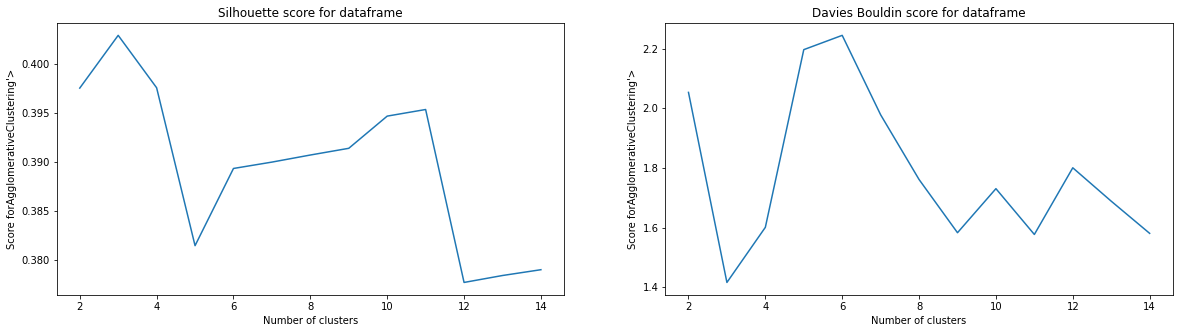

In [49]:
x = np.arange(2, 15)
[score, score_db] = calculate_scores(AgglomerativeClustering, x, df)
plot_score(x, score, score_db, AgglomerativeClustering)

Według metryki silhouette dla oryginalnej ramki danych optymalna liczba klastrów to 2-3, Według indeksu Davisa-Bouldina najbardziej optymalna liczba klastrów to 3.

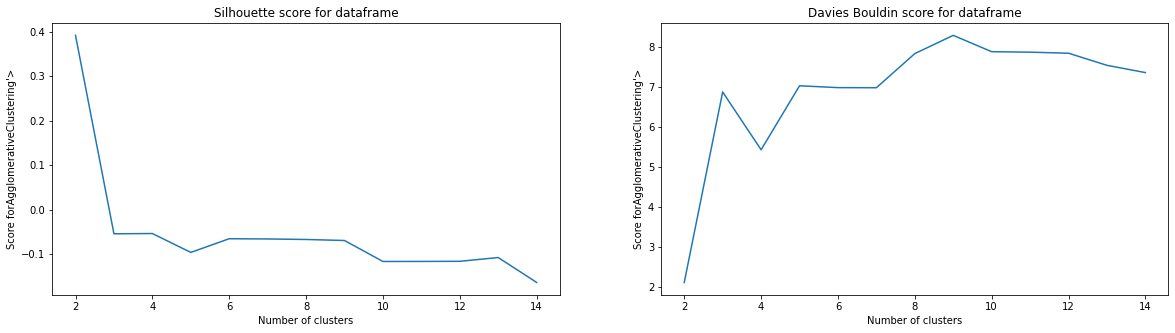

In [50]:
[score, score_db] = calculate_scores(AgglomerativeClustering, x, df_encoded)
plot_score(x, score, score_db, AgglomerativeClustering)

Dla ramki danych zawierającej dodatkowe cechy proponowana liczba klastrów to 3.

#### Wyznaczenie optymalnej liczby klastrów za pomocą dendrogramu
Dendrogram dla bazowej ramki danych.

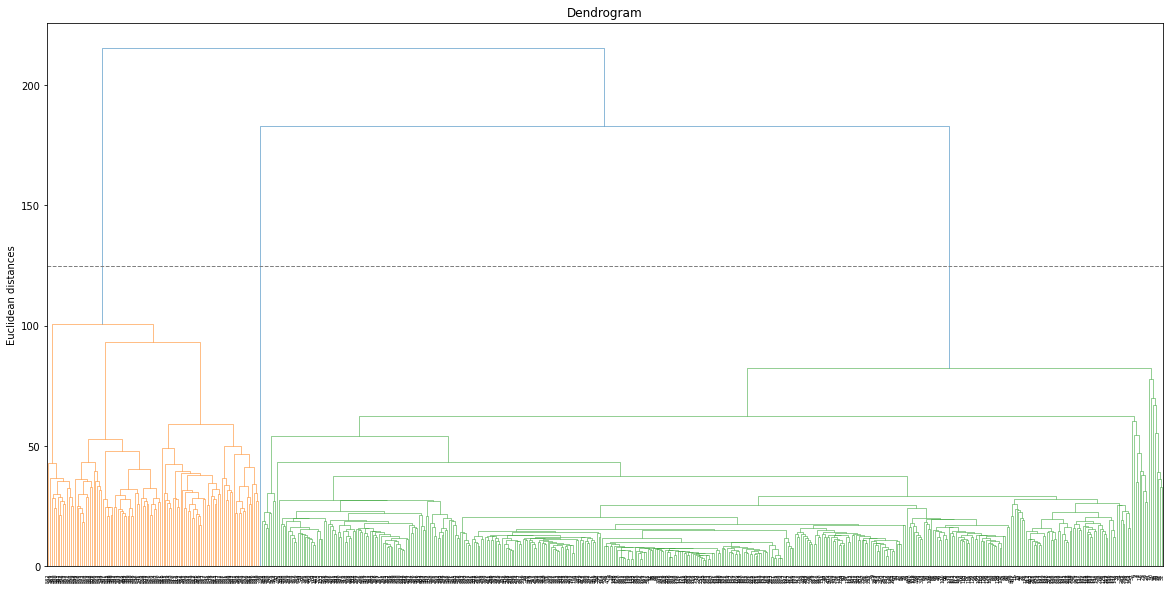

In [52]:
import scipy.cluster.hierarchy as sch

fig, ax = plt.subplots(figsize=(20, 10))
with plt.rc_context({'lines.linewidth': 0.5}):
    ax = sch.dendrogram(sch.linkage(df, method  = "ward"))
plt.title('Dendrogram')
plt.ylabel('Euclidean distances')
plt.axhline(y=125, c='grey', lw=1, linestyle='dashed') 
plt.show()

Dendrogram dla ramki danych zawierającej przeliczone właściwości - optymalna liczba klastrów to 3

In [53]:
df_encoded_no_text = df_corpus_enc_1.iloc[:,1:-2]

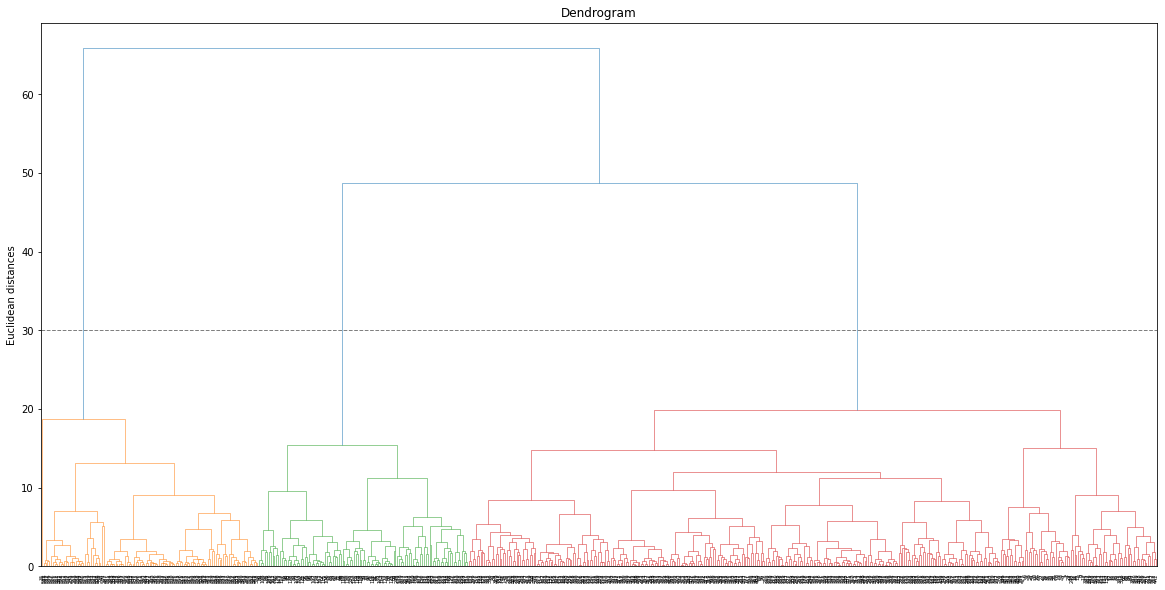

In [54]:
fig, ax = plt.subplots(figsize=(20, 10))
with plt.rc_context({'lines.linewidth': 0.5}):
    ax = sch.dendrogram(sch.linkage(df_encoded_no_text, method  = "ward"))
plt.title('Dendrogram')
plt.ylabel('Euclidean distances')
plt.axhline(y=30, c='grey', lw=1, linestyle='dashed') 
plt.show()

## Ewaluacja

### Testowanie funkcji accuracy

In [56]:
df_corpus_enc_1 = pd.read_csv("df_corpus_enc.csv")
df_corpus_enc_1 = df_corpus_enc_1.iloc[:, 1:-1]

df_corpus_enc_1['label'] = labels
df_corpus_enc_1['label'].unique()
book_dict = {'Buddhism': 'Buddhism', 'TaoTeChing': 'Taoism', 'Upanishad': 'Hiduism' , 'YogaSutra': 'Hiduism',
       'BookOfProverb': 'Christianity', 'BookOfEcclesiastes': 'Christianity', 'BookOfEccleasiasticus': 'Christianity',
       'BookOfWisdom': 'Christianity'}
df_corpus_enc_1['label'] = df_corpus_enc_1['label'].replace(book_dict)

In [57]:
X = df_corpus_enc_1.iloc[:, 1:-1]
check_accuracy(AgglomerativeClustering, X, [2, 3, 4], df_corpus_enc_1)

Przydzielone klasy: ['Hiduism' 'Christianity']
Accuracy: 0.7830508474576271
Przydzielone klasy: ['Hiduism' 'Christianity' 'Taoism']
Accuracy: 0.8016949152542373
Przydzielone klasy: ['Hiduism' 'Buddhism' 'Christianity' 'Taoism']
Accuracy: 0.8033898305084746


Najbardziej trafne predykcje są generowane dla podziału na 4 klastry, przy podziale na 2 oraz 3 klastry predykcje są nieznacznie mniej trafne - wynoszą odpowiednio ok. 0.78 oraz 0.80

## Szybsze podejście?
Powyższa analiza została wykonana w oparciu o wcześniej przygotowane EDA oraz dość skomplikowany feature engineering. Jednak czy może da się prościej, szybciej ale z podobną dokładnością? Zobaczmy :)

Wczytamy na poczatek dane z tabeli z labelami, a następnie przerobimy je tak, by było wygodnie na nich działać, czyli zrobimy z nich data frame, który posiada w pierwszej kolumnie zkonkatenowane wyrazy z wejściowej tablei, a w drugiej label z tekstu (potrzebne do sprawdzenia na koniec).

In [58]:
df_labelled = pd.read_csv('AllBooks_baseline_DTM_Labelled.csv')
df_labelled.head()

,Unnamed: 0,foolishness,hath,wholesome,takest,feelings,anger,vaivaswata,matrix,kindled,...,erred,thinkest,modern,reigned,sparingly,visual,thoughts,illumines,attire,explains
0,Buddhism_Ch1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Buddhism_Ch2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Buddhism_Ch3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Buddhism_Ch4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Buddhism_Ch5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [59]:
labels_1=df_labelled.iloc[:,0]
labels_1

0           Buddhism_Ch1
1           Buddhism_Ch2
2           Buddhism_Ch3
3           Buddhism_Ch4
4           Buddhism_Ch5
             ...        
585    BookOfWisdom_Ch15
586    BookOfWisdom_Ch16
587    BookOfWisdom_Ch17
588    BookOfWisdom_Ch18
589    BookOfWisdom_Ch19
Name: Unnamed: 0, Length: 590, dtype: object

In [60]:
without_labels=df_labelled.drop(df_labelled.columns[0], axis=1)
without_labels

,foolishness,hath,wholesome,takest,feelings,anger,vaivaswata,matrix,kindled,convict,...,erred,thinkest,modern,reigned,sparingly,visual,thoughts,illumines,attire,explains
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
585,0,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
586,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
587,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
588,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [61]:
changed_labels=labels_1.apply(lambda x: 0 if 'Buddhism' in x else (1 if 'TaoTeChing' in x else (2 if 'Upanishad' in x else
(3 if 'YogaSutra' in x else(4 if 'BookOfProverb' in x else(5 if 'BookOfEcclesiastes' in x else (6 if 'BookOfEccleasiasticus' in x else(7 if 'BookOfWisdom' in x else x)))))))).to_frame()

changed_labels=changed_labels.to_numpy()

In [62]:
df_2 = {'text':[], 'label':[]}
df_2 = pd.DataFrame(data=df_2)
for i in range (df_labelled.shape[0]): #tyle jest obserwacji
    a=""
    for col in without_labels.columns:
        val = without_labels[col].values[i]
        if(val!=0):
            a+=int(val)* (str(col)+" ")
    new_row={'text': a, 'label': changed_labels.flat[i]}
    df_2=df_2.append(new_row, ignore_index=True)
df_2

,text,label
0,open mentally mentally i affliction affliction...,0.0
1,staying origination origination disenchantment...,0.0
2,tell thus thus play play play play play short ...,0.0
3,illumination origination origination originati...,0.0
4,stressfulness stressfulness stressfulness stre...,0.0
...,...,...
585,hath hath neither neither soft handle short be...,7.0
586,rage neither neither land land remedy came cam...,7.0
587,neither neither great great overtaken yielding...,7.0
588,diadem neither land guest great came fears ask...,7.0


In [63]:
vec = TfidfVectorizer(stop_words="english")
vec.fit(df_2.text.values)
features = vec.transform(df_2.text.values)

Użyjmy PCA, by zmniejszyć liczbę komponentów do dwóch i zobaczmy co nam potem wyjdzie przy użyciu naszego modelu.

In [64]:
random_state=0
pca = PCA(n_components=2, random_state=random_state)
reduced_features = pca.fit_transform(features.toarray())

Sprawdźmy najpierw jeszcze, jaka liczba klastrów jest najoptymalniejsza według algorytmu metody łokcia oraz silhouette.

In [65]:
def elbow_method(df, k_max):
    scores = []
    for k in range(1, k_max+1):
        kmeans = MiniBatchKMeans(random_state=0, n_clusters=k).fit(df)
        scores.append(kmeans.score(df) * -1)
    return scores

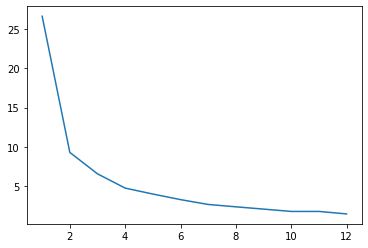

In [66]:
scores=elbow_method(reduced_features,12)
k_max=12
x = list(range(1,k_max + 1))
plt.plot(x, scores)
plt.show()

Według powyższej metody powinniśmy wybrać 2, 3 lub ewentualnie 4 klastry.

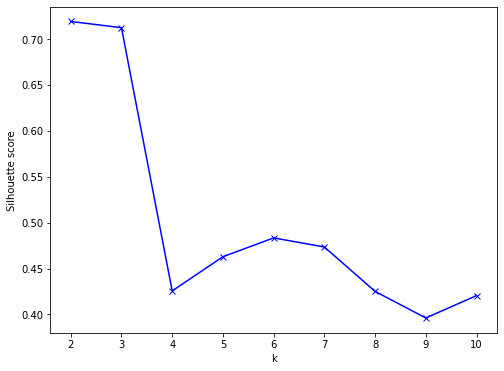

In [67]:
figsize=[8, 6]

cluster_num_seq = range(2, 11) 
silhouette_vec = clustering_scores(reduced_features, cluster_num_seq, MiniBatchKMeans, silhouette_score)
f = plt.figure(figsize=figsize)
plt.plot(cluster_num_seq, silhouette_vec, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette score')
plt.show()

Tym razem możemy zaobserwować, że najlepszy wynik uzyskamy biorąc 2 lub 3 klastry.

Tak więc spróbujmy jak będzie wyglądać predykcja dla MiniBatchKMeans dla przykładowych 8 klastrów.

In [68]:
cls = MiniBatchKMeans(n_clusters=8, random_state=random_state)
cls.fit(features)
cls.predict(features)

array([3, 5, 5, 5, 4, 3, 2, 2, 2, 2, 5, 5, 5, 5, 5, 2, 5, 5, 5, 5, 5, 5,
       2, 2, 2, 3, 5, 5, 5, 5, 5, 5, 3, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 0, 3, 5, 0, 3, 3, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 2, 0,
       0, 2, 0, 0, 0, 5, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       3, 2, 3, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 6, 3, 5, 0, 5, 5, 7, 6, 0, 0, 0, 0, 0, 2, 5, 7, 7, 5,
       7, 7, 7, 5, 7, 5, 5, 5, 4, 5, 5, 5, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 5, 5, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 3, 3, 3, 3,
       7, 5, 5, 5, 7, 5, 3, 7, 7, 3, 5, 5, 5, 7, 3, 5, 5, 7, 7, 5, 7, 5,
       5, 7, 5, 5, 5, 5, 5, 5, 7, 7, 5, 7, 5, 3, 7, 5, 5, 7, 7, 7, 5, 7,
       5, 4, 4, 7, 7, 4, 7, 3, 5, 7, 5, 3, 4, 5, 7, 7, 7, 7, 7, 7, 5, 5,
       6, 5, 2, 7, 5, 5, 5, 5, 2, 5, 4, 5, 5, 5, 7, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 6, 6, 3, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 5, 5, 3,
       5, 5, 2, 2, 2, 2, 2, 2, 5, 2, 2, 2, 2, 2, 2,

In [69]:
from sklearn.metrics import homogeneity_score
homogeneity_score(df_2.label, cls.predict(features))

0.5698720561819484

A także dla dwóch klastrów (musi nastąpić zmiana labeli w tabeli sprawdzającej, by wynik przy pomocy metryki był wiarygodny - podział jest na Chrześcijaństwo vs pozostałe religie).

In [70]:
changed_labels_3=labels_1.apply(lambda x: 0 if 'Buddhism' in x else (0 if 'TaoTeChing' in x else (0 if 'Upanishad' in x else
(0 if 'YogaSutra' in x else(1 if 'BookOfProverb' in x else(1 if 'BookOfEcclesiastes' in x else (1 if 'BookOfEccleasiasticus' in x else(1 if 'BookOfWisdom' in x else x)))))))).to_frame().to_numpy()

In [71]:
df3 = {'text':[], 'label':[]}
df3 = pd.DataFrame(data=df3)
for i in range (df_labelled.shape[0]): #tyle jest obserwacji
    a=""
    for col in without_labels.columns:
        val = without_labels[col].values[i]
        if(val!=0):
            a+=int(val)* (str(col)+" ")
    new_row={'text': a, 'label': changed_labels_3.flat[i]}
    df3=df3.append(new_row, ignore_index=True)
df3

,text,label
0,open mentally mentally i affliction affliction...,0.0
1,staying origination origination disenchantment...,0.0
2,tell thus thus play play play play play short ...,0.0
3,illumination origination origination originati...,0.0
4,stressfulness stressfulness stressfulness stre...,0.0
...,...,...
585,hath hath neither neither soft handle short be...,1.0
586,rage neither neither land land remedy came cam...,1.0
587,neither neither great great overtaken yielding...,1.0
588,diadem neither land guest great came fears ask...,1.0


In [72]:
vec3 = TfidfVectorizer(stop_words="english")
vec3.fit(df3.text.values)
features3 = vec3.transform(df3.text.values)

In [73]:
cls3 = MiniBatchKMeans(n_clusters=2, random_state=random_state)
cls3.fit(features3)

MiniBatchKMeans(n_clusters=2, random_state=0)

In [74]:
cls3.predict(features3)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [75]:
pca3 = PCA(n_components=2, random_state=random_state)
reduced_features = pca3.fit_transform(features3.toarray())

In [76]:
from sklearn.metrics import homogeneity_score
homogeneity_score(df3.label, cls3.predict(features3))

0.9144605503896787

Wyniki uzyskane w szczególności dla podziału na dwa klastry nie wyglądają tak źle. Przy następnym checkpoincie sprawdzimy, z pomocą większej ilości metryk, jak bardzo różnią się dokładnościami przewidywanych wyników te dwa podejścia.